In [134]:
from mnist import MNIST
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, '../../Libraries')
import JacksonsTSPackage as jts
from statsmodels.tsa.api import VAR
from statsmodels.tsa.ar_model import AutoReg

In [135]:
np.random.seed(123)
data = [np.random.uniform(0, 1) + 5]

N = 800

e = 1
for i in range(1, N + 10):
    data.append(0.8*data[i-1] + np.random.uniform(-e, e) + np.sin(i/ 20))

data = pd.DataFrame(data[10:(N + 10)])

In [136]:
data

,0
0,2.182413
1,2.726717
2,2.623160
3,1.823070
4,1.898763
...,...
795,3.832744
796,3.116977
797,3.945307
798,3.349211


<AxesSubplot:>

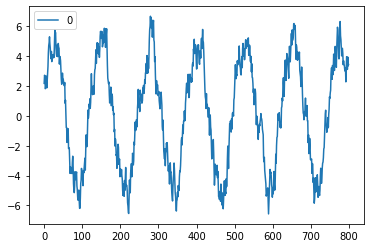

In [137]:
data.plot()

In [138]:
N_test = 80
N_train = N - N_test
print(f"N: {N}")
print(f"N_train: {N_train}")
print(f"N_test: {N_test}")

N: 800
N_train: 720
N_test: 80


In [139]:
rounded_data = data.to_numpy()
min_val = min(rounded_data)
max_val = max(rounded_data)
print(f"Min: {min_val}")
print(f"Max: {max_val}")

Min: [-6.57611761]
Max: [6.68426652]


In [140]:
rounded_data = [i + 7 for i in rounded_data]
rounded_data = [(i*9)/(max_val - min_val) for i in rounded_data]

In [141]:
rounded_data = [np.round(i) for i in rounded_data]
rounded_data = [int(i) for i in rounded_data]
rounded_data[0:5]

[6, 7, 7, 6, 6]

In [142]:
Counter(rounded_data)

Counter({6: 105,
         7: 127,
         8: 111,
         9: 33,
         5: 91,
         4: 71,
         3: 71,
         2: 108,
         1: 79,
         0: 4})

<AxesSubplot:>

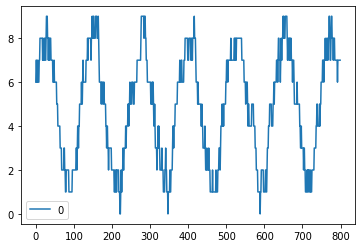

In [143]:
pd.DataFrame(rounded_data).plot()

In [144]:
Counter(rounded_data)

Counter({6: 105,
         7: 127,
         8: 111,
         9: 33,
         5: 91,
         4: 71,
         3: 71,
         2: 108,
         1: 79,
         0: 4})

<AxesSubplot:>

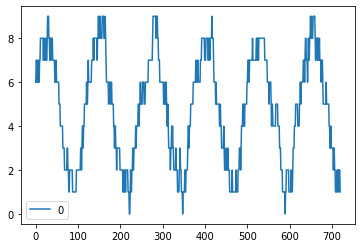

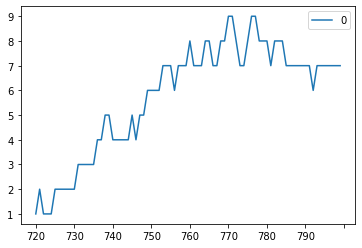

In [145]:
train = pd.DataFrame(rounded_data[:N_train])
test = pd.DataFrame(rounded_data[N_train:], index = [str(i) for i in range(N_train, N)])
train.plot()
test.plot()

<AxesSubplot:>

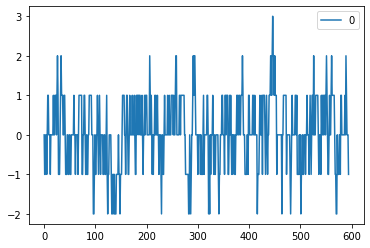

In [146]:
interval = 125
train_diff = jts.calc_seasonal_diff(train, interval)
train_diff.plot()

In [194]:
jts.mts_adf(train_diff)

    Augmented Dickey-Fuller Test on "0" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = nan
 No. Lags Chosen       = 0
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = nan
 No. Lags Chosen       = 0
 Critical value 1%     = -3.441
 Critical value 5%     = -2.866
 Critical value 10%    = -2.569
 => P-Value = nan. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Si

In [147]:
model = AutoReg(train_diff.values, lags = 1)
fit = model.fit()
pred_diff = pd.DataFrame(fit.predict(start = N_train, end = N - 1), index = [str(i) for i in range(N_train, N)])

In [149]:
pred = jts.invert_diff_transformation(pred_diff, train, interval)

<AxesSubplot:>

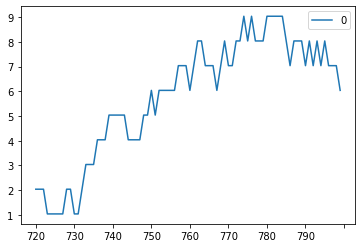

In [150]:
pred.plot()

<AxesSubplot:>

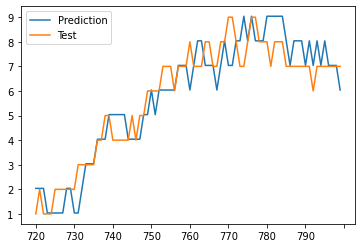

In [151]:
pred.columns = ["Prediction"]
test.columns = ["Test"]
df = pd.concat([pred, test], axis = 1)
df.plot()

In [152]:
jts.forecast_accuracy(pred, test)

Results
----------------------------------------------------------------------
           ME            MSE            MAE            MAPE
Test    0.013          0.800          0.666          14.797%       


In [153]:
mndata = MNIST('./Data')
images, labels = mndata.load_training()
labels = labels.tolist()
images = [x for _,x in sorted(zip(labels,images))]
labels.sort()

label_counts = list(Counter(labels).values())

tensor_shape = (N, 28, 28)
data_tensor = np.empty(tensor_shape)

for i in range(N):

    curr_num = rounded_data[i]

    # Pick a random number within that number range
    offset = sum(label_counts[:(curr_num)])
    ran_index = np.random.randint(offset, offset + label_counts[curr_num])

    # Set that random images inside our tensor
    tmp = np.asarray(images[ran_index])
    tmp.resize((tensor_shape[1], tensor_shape[2]))
    data_tensor[i] = tmp

array([6, 7, 7, 6, 6, 7, 6, 6, 6, 7, 7, 8, 8, 8, 8, 8, 8, 8, 7, 8, 7, 7,
       7, 8, 8, 7, 7, 8, 9, 9, 9, 8, 8, 7, 8, 8, 7, 8, 8, 8])

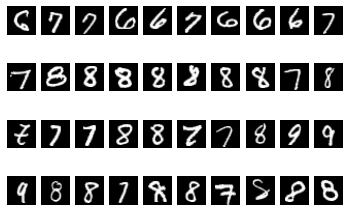

In [154]:
jts.implot_tensor(data_tensor, (4, 10))
np.array(rounded_data[0:40])

In [155]:
train_tensor = jts.extract_train_tensor(data_tensor, N_train)
test_tensor = jts.extract_test_tensor(data_tensor, N_train, N_test)

In [156]:
train_dwt = jts.apply_dwt_to_tensor(train_tensor)
train_dwt

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [157]:
train_model_sets = jts.split_cols_into_model_sets(train_dwt, N_train)
test_model_sets = jts.split_cols_into_model_sets(test_tensor, N_test)

In [202]:
result_model_sets = np.empty((tensor_shape[2], N_test, tensor_shape[1]))
result_model_sets_diff = np.empty((tensor_shape[2], N_test, tensor_shape[1]))

for i in range(28):
    train_df = pd.DataFrame(train_model_sets[i])
    test_df = pd.DataFrame(test_model_sets[i])
    train_diff = jts.calc_seasonal_diff(train_df, interval)
    model = VAR(train_diff)
    fit = model.fit(1)

    test_df.columns = test_df.columns[:].astype(str)

    results_diff = jts.forecast(fit, train_diff, test_df, N_test, calc_conf = False)

    result_model_sets_diff[i] = results_diff
    result_model_sets[i] = jts.invert_diff_transformation(results_diff, train_df, interval)

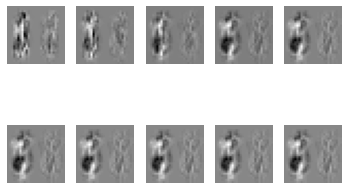

In [203]:
jts.implot_tensor(jts.collect_result_cols_into_tensor(result_model_sets_diff, N_test), (2, 5))

In [204]:
result_dwt_tensor = jts.collect_result_cols_into_tensor(result_model_sets, N_test)

In [205]:
result_tensor = jts.apply_inverse_dwt_to_tensor(result_dwt_tensor)

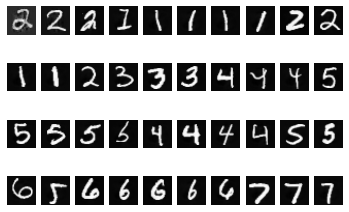

In [206]:
jts.implot_tensor(result_tensor, (4, 10))

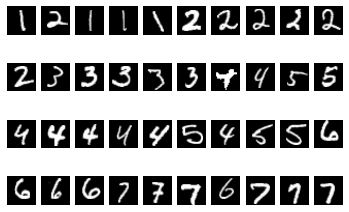

In [207]:
jts.implot_tensor(test_tensor, (4, 10))

In [209]:
error = jts.calc_mape_per_matrix(test_tensor, result_tensor)
error = error.rename(columns={"MAPE": "2D-VAR"})
error

,2D-VAR
0,1.58563
1,1.08817
2,2.05009
3,1.7479
4,0.91321
...,...
75,1.08118
76,0.973078
77,0.709374
78,1.40055


<AxesSubplot:>

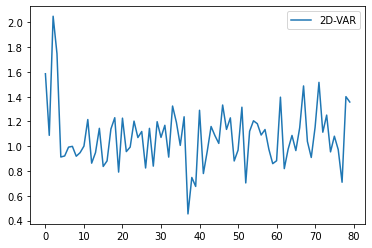

In [210]:
    error.plot()